# Speech Emotion Recognizer
## Dataset:
[The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)
](https://zenodo.org/record/1188976)

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

import os
import librosa
import librosa.display
from IPython.display import Audio

from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

### Load Data

Filename identifiers 

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

*We only need `emotion [index 2]` and `emotional intensity [index 3]` from the identifiers*

In [3]:
emotion = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', 
                '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
emotional_intensity = {'01': 'normal', '02': 'strong'}

# function to parse filename identifiers into readable lables
def parse_filename_identifiers(filename):
    filename = filename.split('.')[0] # remove any file extensions like .wav
    identifiers = filename.split('-') # split it into identifiers
    # convert identifiers to readable names and return it
    return (emotion[identifiers[2]], emotional_intensity[identifiers[3]])

In [4]:
paths = []
labels = []
dir_name = "Audio_Speech_Actors_01-24"
for root, directories, files in os.walk(dir_name):
    for f in files:
        paths.append(os.path.join(root, f))
        labels.append(parse_filename_identifiers(f))
        # label = filename.split('_')[-1]
        # label = label.split('.')[0]
        # labels.append(label.lower())
print('Dataset is Loaded')

Dataset is Loaded


In [5]:
# path: location of audio files
print("Number of Audio Files:", len(paths))
print("First 5 Audio File Paths:")
print(paths[:5])

print()
# labels: emotions attached to the audio file
print("Emotions: ")
pprint(set(labels))
print("First 5 Audio File Emotions:")
print(labels[:5])

Number of Audio Files: 1440
First 5 Audio File Paths:
['Audio_Speech_Actors_01-24\\Actor_01\\03-01-01-01-01-01-01.wav', 'Audio_Speech_Actors_01-24\\Actor_01\\03-01-01-01-01-02-01.wav', 'Audio_Speech_Actors_01-24\\Actor_01\\03-01-01-01-02-01-01.wav', 'Audio_Speech_Actors_01-24\\Actor_01\\03-01-01-01-02-02-01.wav', 'Audio_Speech_Actors_01-24\\Actor_01\\03-01-02-01-01-01-01.wav']

Emotions: 
{('angry', 'normal'),
 ('angry', 'strong'),
 ('calm', 'normal'),
 ('calm', 'strong'),
 ('disgust', 'normal'),
 ('disgust', 'strong'),
 ('fearful', 'normal'),
 ('fearful', 'strong'),
 ('happy', 'normal'),
 ('happy', 'strong'),
 ('neutral', 'normal'),
 ('sad', 'normal'),
 ('sad', 'strong'),
 ('surprised', 'normal'),
 ('surprised', 'strong')}
First 5 Audio File Emotions:
[('neutral', 'normal'), ('neutral', 'normal'), ('neutral', 'normal'), ('neutral', 'normal'), ('calm', 'normal')]


In [6]:
df = pd.DataFrame()
df['path'] = paths
df['emotion'] = [emotion for emotion, _ in labels]
df['intensity'] = [intensity for _, intensity in labels]
print(df)

                                                   path    emotion intensity
0     Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...    neutral    normal
1     Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...    neutral    normal
2     Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...    neutral    normal
3     Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...    neutral    normal
4     Audio_Speech_Actors_01-24\Actor_01\03-01-02-01...       calm    normal
...                                                 ...        ...       ...
1435  Audio_Speech_Actors_01-24\Actor_24\03-01-08-01...  surprised    normal
1436  Audio_Speech_Actors_01-24\Actor_24\03-01-08-02...  surprised    strong
1437  Audio_Speech_Actors_01-24\Actor_24\03-01-08-02...  surprised    strong
1438  Audio_Speech_Actors_01-24\Actor_24\03-01-08-02...  surprised    strong
1439  Audio_Speech_Actors_01-24\Actor_24\03-01-08-02...  surprised    strong

[1440 rows x 3 columns]


### Exploratory Data Analysis

<AxesSubplot:xlabel='emotion', ylabel='count'>

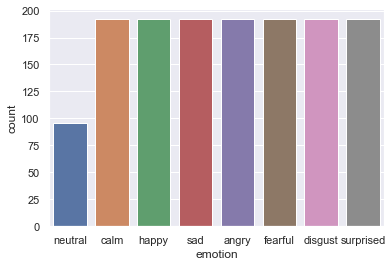

In [7]:
# check for imbalance classes
sb.countplot(x='emotion', data=df)

<AxesSubplot:xlabel='emotion', ylabel='count'>

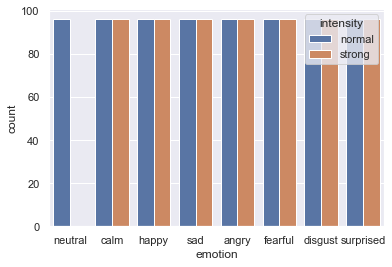

In [8]:
sb.countplot(x='emotion', hue='intensity', data=df)

Observation: `neutral` has half the number of data as it does not have a `strong` intensity

In [9]:
def wave_plot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.show()


def spectogram(data, sampling_rate, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
    plt.colorbar()

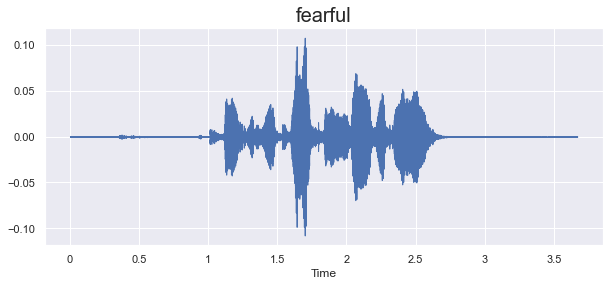

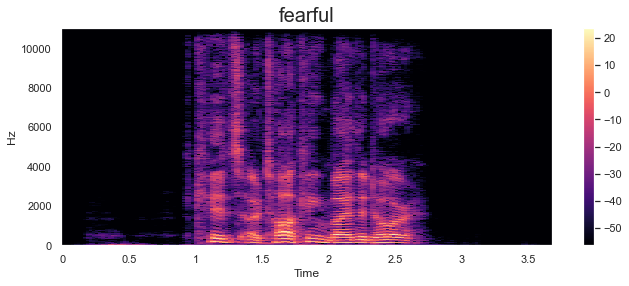

In [10]:
emotion = 'fearful'
path = np.array(df['path'][df['emotion'] == emotion])[0]
data, sampling_rate = librosa.load(path)
wave_plot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Extract Features

In [11]:
def extract_features(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    '''
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    chroma_cqt = np.mean(librosa.feature.chroma_cqt(y=y, sr=sr).T, axis=0)
    melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y,sr=sr).T,axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T,axis=0)
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y).T,axis=0)
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr).T,axis=0)
    poly_features = np.mean(librosa.feature.poly_features(y=y, sr=sr).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=y, sr=sr).T,axis=0)
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y).T, axis=0)
    tempogram = np.mean(librosa.feature.tempogram(y=y, sr=sr).T, axis=0)
    fourier_tempogram = np.mean(librosa.feature.fourier_tempogram(y=y, sr=sr).T, axis=0)
    print(chroma_stft.shape)
    print(chroma_stft)
    print(tempogram)
    '''
    return mfcc

In [12]:
extract_features(df['path'][0])

array([-6.7043011e+02,  6.5463234e+01,  4.8822173e-01,  1.5117002e+01,
        8.7833891e+00,  1.0563951e+00, -4.2406769e+00, -3.1930439e+00,
       -1.3346265e+01, -2.9177351e+00,  5.3375745e-01, -3.2262833e+00,
        2.0105293e+00, -4.0300112e+00,  1.9380902e-01,  1.2353785e+00,
       -5.1382542e+00, -1.7780106e+00, -1.9244384e+00, -7.4367237e-01,
       -7.3666172e+00, -3.3326355e-01, -3.0078795e+00, -5.0382442e+00,
       -2.2274771e+00, -6.9816214e-01, -5.9582076e+00,  5.5907118e-01,
       -2.7585127e+00,  3.8554960e-01, -2.5434520e+00, -2.3236392e+00,
       -3.3210137e+00, -2.0330336e+00, -3.9490013e+00, -1.6773354e+00,
       -1.3858986e+00, -2.0310066e+00, -4.2552681e+00, -1.6869317e+00],
      dtype=float32)

In [13]:
X_mfcc = df ['path'].apply(lambda x: extract_features(x))
X_mfcc

0       [-670.4301, 65.463234, 0.48822173, 15.117002, ...
1       [-660.48267, 63.75066, -3.056129, 18.408236, 8...
2       [-662.1772, 67.02389, -1.3007649, 15.267228, 4...
3       [-657.94543, 65.41852, 2.7653725, 16.049337, 7...
4       [-694.8559, 72.9893, 2.6462479, 17.569914, 8.6...
                              ...                        
1435    [-554.8638, 29.077559, -20.890728, -1.4793975,...
1436    [-472.46924, 49.998795, -20.054127, -7.3047585...
1437    [-477.8846, 39.637897, -24.677713, -3.4138582,...
1438    [-445.2368, 30.085903, -7.9774055, 2.8382914, ...
1439    [-485.58624, 35.066917, -3.231613, -2.1926942,...
Name: path, Length: 1440, dtype: object